In [171]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import collections
sns.set(style="whitegrid")

In [178]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.std = features.groupby(target).apply(np.std).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var

    def get_stats(self):
        return self.mean, self.var, self.prior
    
    def get_target(self):
        print(np.mean(self.mean.flatten()))
        print(np.mean(self.std.flatten()))
        print(self.prior)
        print(self.target.shape)
        print(self.features.shape)
        return self.target

    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.target = target.to_numpy()
        self.features = features.to_numpy()

        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        print("Y_TRUE: ", len(y_test))
        print("Y_PRED: ", len(y_pred))
        print("SUM: ", np.sum(y_test == y_pred))
        unique, counts = np.unique(y_test, return_counts=True)
        print("COUNTER Y_TEST: ", dict(zip(unique, counts)))
        unique, counts = np.unique(y_pred, return_counts=True)
        print("COUNTER Y_PRED: ", dict(zip(unique, counts)))
        print()
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()


In [179]:
# Sentiment Analysis with Naive Bayes 

In [206]:
emails = pd.read_csv("spambase.data")
# emails.head(2)
# emails['1'].value_counts()
# emails['spam'] = emails['1']
# emails = emails.drop(columns=['1'])
# emails['spam'] = emails['spam'].map({1: "spam", 0: "not_spam"}) 
# emails['spam'].value_counts()
# print(emails.shape)
# emails.head()

X,y = emails.iloc[:, :-1], emails.iloc[:, -1]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, shuffle=True, random_state=42)
model = NaiveBayesClassifier()
model.fit(X_train, y_train)
print(type(y_test))
print(model.get_target())
print()
# print(model.get_stats())
preds = model.predict(X_test)
print("LEN: ", len(preds))
print()
model.accuracy(y_test, preds)

<class 'pandas.core.series.Series'>
6.897414786648971
13.993542966105965
[0.6161122 0.3838878]
(3066,)
(3066, 57)
[1 0 0 ... 0 0 1]

LEN:  1534

Y_TRUE:  1534
Y_PRED:  1534
SUM:  1213
COUNTER Y_TEST:  {0: 899, 1: 635}
COUNTER Y_PRED:  {0: 636, 1: 898}

<ipython-input-178-86357aef3f1f>:58: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable


0.7907431551499348

In [207]:
y_train

221     1
3834    0
4254    0
3593    0
1876    0
       ..
4426    0
466     1
3092    0
3772    0
860     1
Name: 1, Length: 3066, dtype: int64

In [208]:
model.accuracy(y_test, preds)

Y_TRUE:  1534
Y_PRED:  1534
SUM:  1213
COUNTER Y_TEST:  {0: 899, 1: 635}
COUNTER Y_PRED:  {0: 636, 1: 898}



0.7907431551499348

In [209]:
model.visualize(y_test, preds, 'spam')

ValueError: min() arg is an empty sequence

In [737]:
# compare to sklearn Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [738]:
clf = GaussianNB()

In [557]:
# iris dataset
clf.fit(X_train, y_train)

GaussianNB()

In [558]:
preds = clf.predict(X_test)

In [559]:
clf.score(X_test, y_test)

0.92

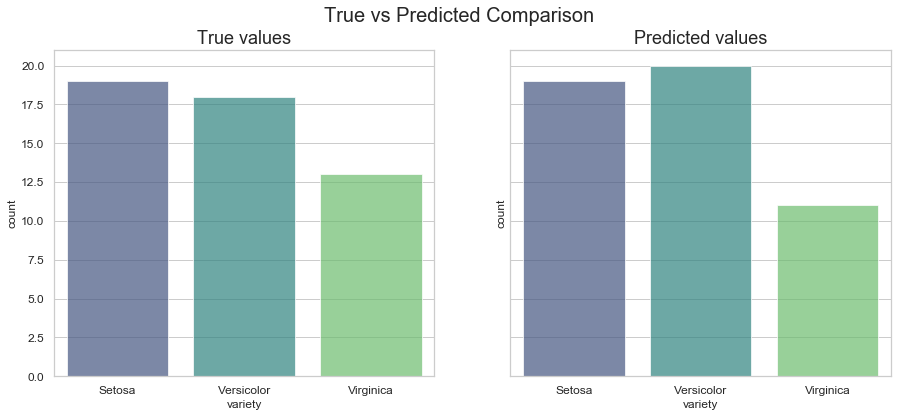

In [562]:
tr = pd.DataFrame(data=y_test, columns=['variety'])
pr = pd.DataFrame(data=preds, columns=['variety'])


fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))

sns.countplot(x='variety', data=tr, ax=ax[0], palette='viridis', alpha=0.7)
sns.countplot(x='variety', data=pr, ax=ax[1], palette='viridis', alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()

In [844]:
#emails dataset 
clf1 = GaussianNB()

In [845]:
clf1.fit(X_train, y_train)

GaussianNB()

In [846]:
preds1 = clf1.predict(X_test)

In [847]:
# prediced better for emails classifications
clf1.score(X_test, y_test)

0.8181159420289855

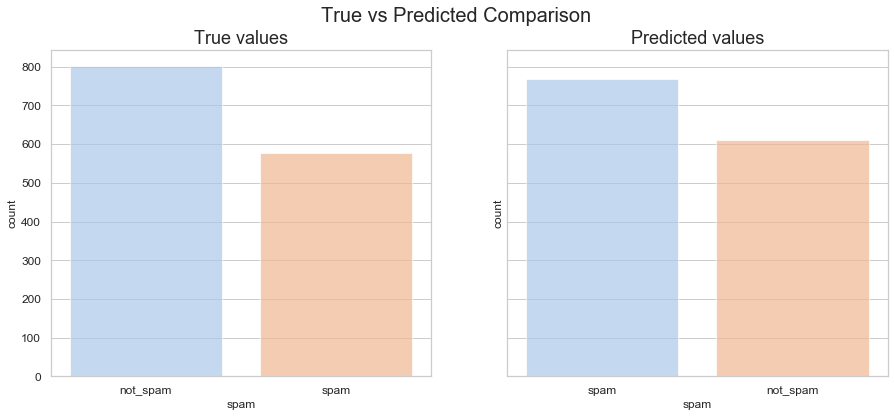

In [848]:
test_df = pd.DataFrame(data=y_test, columns=['spam'])
pred_df = pd.DataFrame(data=preds1, columns=['spam'])
    
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
sns.countplot(x='spam', data=test_df, ax=ax[0], palette='pastel', alpha=0.7)
sns.countplot(x='spam', data=pred_df, ax=ax[1], palette='pastel', alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()